In [7]:
import galsim
import time
from usid_processing import parallel_compute
from functools import partial

from utils import *
from model import *
from plotting import *

%load_ext autoreload
%autoreload 2

############################################
# Setup
############################################

# Fitting Parameter
n_cpu = 3
RUN_FITTING = True
print_progress = True
draw = True
save = False
use_SE_seg = False
mask_dual = True
mask_strip = True
wid_strip, n_strip = 10, 14

dir_name = "./real"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Image Parameter
image_size = 800

# patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 800, 1800, 1800, 2800  # image coords
# patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 800, 600, 1800, 1600   # image coords
patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 3100, 1400, 4100, 2400   # image coords

pixel_scale = 2.5                                # arcsec/pixel
psf_scale = 1.5                                  # arcsec/pixel

# PSF Parameters
beta_psf = 10                                     # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                         # moffat fwhm, in arcsec

gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pixel_scale                  # moffat core width, in pix

n = 3.3                     # estimated true power index
frac = 0.3                  # fraction of power law component (from fitting stacked PSF)
theta_t = 5.                # radius at which power law is flattened, in arcsec (arbitrary)

theta_t_pix = theta_t/pixel_scale          # flattened radius, in pix
theta_t_psf_pix = theta_t/psf_scale        # flattened radius in psf, in pix

mu: 460.20 , std: 3.00 , ZP: 27.10 , pix_scale: 2.50


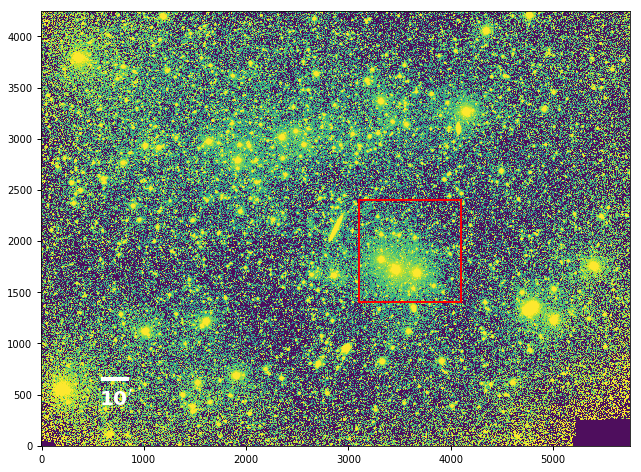

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


In [9]:
############################################
# Read
############################################

hdu = fits.open("./data/coadd_SloanG_NGC_5907.fits")[0]

data = hdu.data
header = hdu.header
seeing = 2.5

mu, sigma = np.float(hdu.header["BACKVAL"]), 3   # Backgroundlevel and estimated std
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, sigma, ZP, pix_scale))

# Crop image
pad = ((patch_Xmax0-patch_Xmin0)-image_size)//2
patch_Xmin, patch_Ymin = patch_Xmin0 + pad, patch_Ymin0 + pad
patch_Xmax, patch_Ymax = patch_Xmax0 - pad, patch_Ymax0 - pad

image_bounds0 = (patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0)
# image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
patch0, seg_patch0 = crop_image(data, image_bounds0, sky_mean=mu, sky_std=sigma, draw=True)

# Read measurement for faint stars from SE 
SE_cat_full = Table.read("./SE_APASS/coadd_SloanG_NGC_5907.cat", format="ascii.sextractor")
SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP
SE_cat = crop_catalog(SE_cat_full, bounds=(patch_Xmin,patch_Ymin,patch_Xmax,patch_Ymax))
SE_cat = SE_cat[SE_cat['RMAG_AUTO']>=15]   # For faint star > 15 mag, use SE flux (won't be modeled)

# Read measurement for bright stars
R_scale = 10
table_res_Rnorm = Table.read("./NGC_5907-G-Rnorm_%dpix_15mag_X%dY%d.txt"\
                             %(R_scale, patch_Xmin0, patch_Ymin0), format="ascii")
table_res_Rnorm = crop_catalog(table_res_Rnorm, bounds=(patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0))

In [10]:
############################################
# Distribution
############################################

# Generate Grid
yy, xx = np.mgrid[:image_size, :image_size]
cen = ((image_size-1)/2., (image_size-1)/2.)

# Positions & Flux of faint stars from SE
star_pos1 = np.vstack([SE_cat['X_IMAGE'],SE_cat['Y_IMAGE']]).T - [patch_Xmin, patch_Ymin]
Flux1 = np.array(SE_cat['FLUX_AUTO'])

# Positions & Flux (estimate) of faint stars from measured norm
star_pos2 = np.vstack([table_res_Rnorm['X_IMAGE'],table_res_Rnorm['Y_IMAGE']]).T - [patch_Xmin, patch_Ymin]
sky_local = np.median(table_res_Rnorm['sky'].data)
z_norm = table_res_Rnorm['mean'].data - sky_local   # <15 mag
Amp_pow = z_norm * (R_scale/theta_t_pix)**n
Flux_pow = power2d_Amp2Flux(n, theta_t_pix, Amp=Amp_pow)
Flux2 = Flux_pow / frac

# Thresholds affecting speed and accuracy depending on the
# actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance.
# Very bright stars are rendered in real space.
F_bright = 3e5#6e4
F_verybright = 5e6#2e6

# 0.25 arcmin out of field
out_of_field_b = np.logical_or.reduce((star_pos2<-6)|(star_pos2>image_size+6), axis=1) \
                                    & (Flux2>F_bright) & (Flux2<F_verybright)
# 1 arcmin out of field
out_of_field_vb = np.logical_or.reduce((star_pos2<-24)|(star_pos2>image_size+24), axis=1) & (Flux2>=F_verybright)

out_of_field = out_of_field_b | out_of_field_vb

# remove stars far from field edge
z_norm = z_norm[~out_of_field]
star_pos2 = star_pos2[~out_of_field]
Flux2 = Flux2[~out_of_field]

# combine 
star_pos = np.vstack([star_pos1, star_pos2])
Flux = np.concatenate([Flux1, Flux2])

# Convert Flux to Astropy Moffat Amplitude (pixel)
Amps = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Flux])

bright = Flux > F_bright
verybright = Flux >= F_verybright
medbright = bright & (~verybright)
num_medbright = len(Flux[medbright])
num_verybright = len(Flux[verybright])
print("# of medium bright (flux:%.2g~%.2g) stars: %d "%(Flux[bright].min(), Flux[verybright].min(), num_medbright))
print("# of very bright (flux>%.2g) stars : %d"%(Flux[verybright].min(), num_verybright))

# Rendering stars in parallel if number of bright stars exceeds 50
if num_medbright < 50:
    print("Not many bright stars, truth and mock will be generated in serial.")
    parallel = False 
else: 
    parallel = True
    print("Crowded fields with bright stars > 50, truth and mock will be generated in parallel.")

    def map2d(f, xx, yy):
        return f(xx,yy)

    p_map2d = partial(map2d, xx=xx, yy=yy)

# if draw:
#     import seaborn as sns
#     sns.distplot(np.log10(z_norm),label="log Norm")
#     sns.distplot(np.log10(Amps),label="log Amp (tot)")
#     Amp_pow_s = power2d_Flux2Amp(n, theta_t_pix, Flux=frac*Flux)                     
#     sns.distplot(np.log10(Flux),label="log Flux (tot)")
#     plt.axvline(np.log10(F_bright), color="orange", ls="-",alpha=0.6)
#     plt.axvline(np.log10(F_verybright), color="orange", ls="--",alpha=0.8)
#     plt.title("Flux & Amp from $create{\_}APASS{\_}photometric$")
#     plt.legend()

# of medium bright (flux:3e+05~2.2e+07) stars: 19 
# of very bright (flux>2.2e+07) stars : 3
Not many bright stars, truth and mock will be generated in serial.


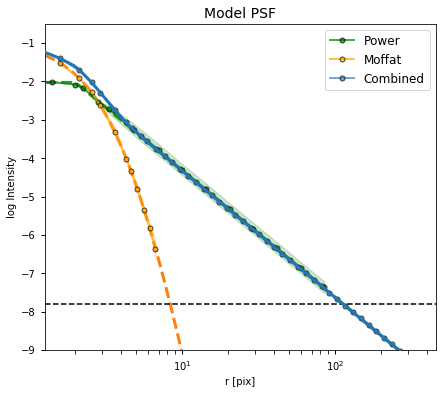

In [12]:
# Define the Power PSF profile, one for making truth in galsim, one for display.
psf_pow_1, psf_size_1 = Generate_PSF_pow_Galsim(n=n, theta_t=theta_t,
                                                psf_range=64*pixel_scale,
                                                psf_scale=psf_scale)
psf_pow_2, psf_size_2 = Generate_PSF_pow_Galsim(n=n, theta_t=theta_t,
                                                psf_range=image_size//2*pixel_scale, 
                                                psf_scale=psf_scale)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1e-7)
psf_mof = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec
star_psf = (1-frac) * psf_mof + frac * psf_pow_2

if draw:
    params = {"gamma":gamma, "beta":beta_psf, "frac":frac, "n":n, 'theta_0':theta_t}
    contrast = Amps.max()/sigma*3
    plot_PSF_model_galsim(psf_mof, psf_pow_2, params, image_size, pix_scale,
                          contrast=contrast, model_aureole="Power")

In [13]:
############################################
# Setup Image
############################################

print("Generate noise background w/ stddev = %.2g."%sigma)
noise_image = make_noise_image(image_size, sigma**2)
    
# Setup the base image for faint stars (Moffat only):
# def make_base_image(image_size, star_pos, Flux):
#     if len(star_pos) == 0:
#         return np.zeros((image_size, image_size))
#     start = time.time()
#     full_image0 = galsim.ImageF(image_size, image_size)
    
#     # draw faint stars in Moffat with galsim in Fourier space   
#     for k in range(len(star_pos)):
#         try:
#             draw_star(k, star_pos=star_pos, Flux=Flux,
#                       psf_star=psf_mof, psf_size=64, full_image=full_image0)
#         except Exception as e:
#             print(e.__doc__)
#             print(e.message)

#     image_gs0 = full_image0.array
#     end = time.time()
#     print("Total Time: %.3fs"%(end-start))
#     return image_gs0

print("Generate base image of faint stars (flux < %.2g)."%(F_bright))
image_gs0 = make_base_image(image_size, psf_base=star_psf,
                            star_pos=star_pos[~bright], Flux=Flux[~bright])

image0 = patch0.copy()
image = image0[pad:-pad,pad:-pad]

Generate noise background w/ stddev = 3.
Generate base image of faint stars (flux < 3e+05).


Mask inner regions of stars in dual mode:  S/N > 3 / r < 72 (24) pix 
Use sky strips crossing very bright stars


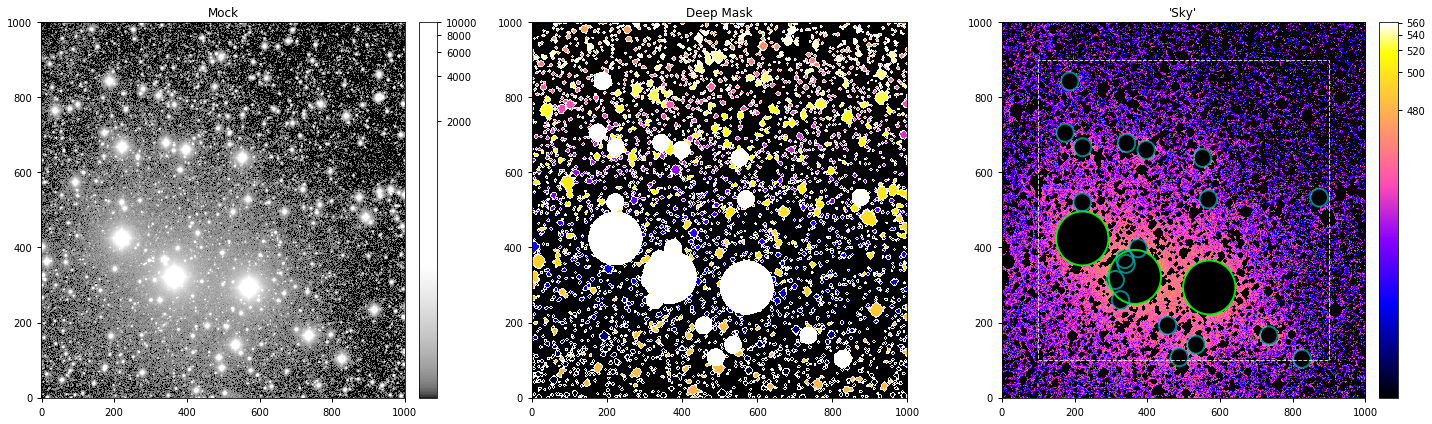

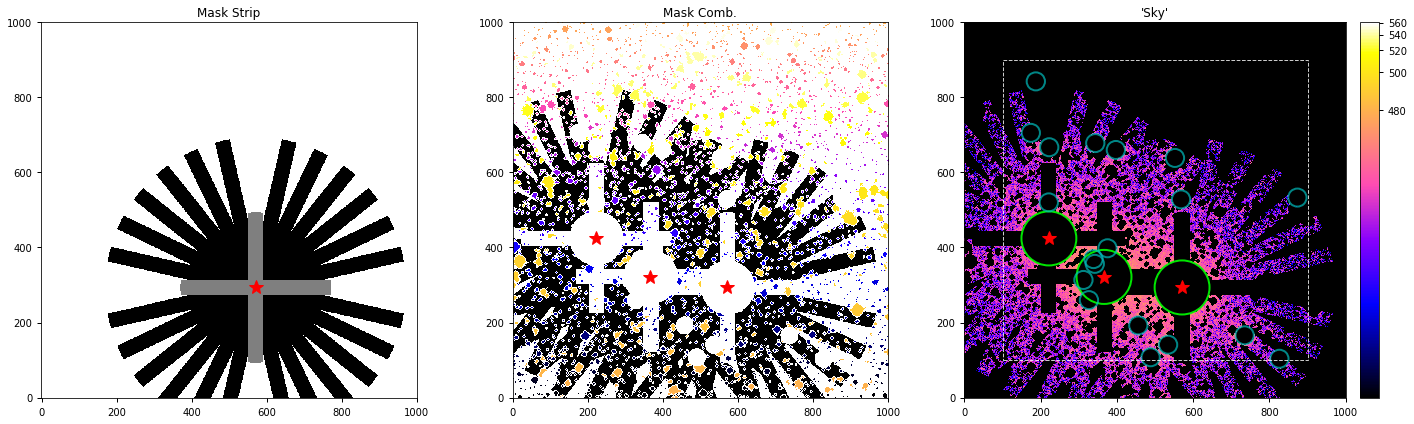

In [18]:
############################################
# Make Mask
############################################

# Make mask map for fitting
if use_SE_seg:
    print("Mask inner regions of stars. Use segmentation based on APASS")
    seg_map0 = seg_patch0.copy()
    for i in range(5):
        seg_map0 = morphology.dilation(seg_map0)
    mask_deep0 = (seg_map0!=0)
else:
    if mask_dual:
        r_core_s = np.array([12 if F < F_verybright else 24 for F in Flux[bright]])
        r_core_s = np.array([24 if F < F_verybright else 72 for F in Flux[bright]])
        r_core_A, r_core_B = np.unique(r_core_s)[::-1]
        print("Mask inner regions of stars in dual mode:  S/N > 3 / r < %d (%d) pix "%(r_core_A, r_core_B))
        mask_deep0, seg_map0, _ = make_mask_map_dual(image0, star_pos=star_pos[bright]+pad,
                                                     r_core=r_core_s, nlevels=128, contrast=0.001,
                                                     sn_thre=3, b_size=25, npix=4, n_dilation=3)
    else:
        print("Mask inner regions of stars (threshold: S/N = 2.5)")
        mask_deep0, seg_map0 = make_mask_map(image0, sn_thre=3, b_size=25, npix=4, n_dilation=1)

mask_deep = mask_deep0[pad:-pad, pad:-pad]
seg_map = seg_map0[pad:-pad, pad:-pad]
    
if draw:
    draw_mask_map(image0, seg_map0, mask_deep0, star_pos[verybright]+pad, star_pos[medbright]+pad, 
                  r_core=[r_core_A, r_core_B], pad=0, vmin=mu, vmax=mu+100, save=save)

if mask_strip:
    print("Use sky strips crossing very bright stars")
    mask_strip_s, mask_cross_s = make_mask_strip(image_size+pad*2, star_pos[verybright]+pad, Flux[verybright]+pad, 
                                                 width=wid_strip, n_strip=n_strip, dist_strip=400)
    mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
    mask_cross_all = ~np.logical_or.reduce(mask_cross_s)
    seg_comb0 = seg_map0.copy()
    seg_comb0[(mask_strip_all|~mask_cross_all)&(seg_map0==0)] = seg_map0.max()+1
    mask_comb0 = (seg_comb0!=0)
    
    mask_comb = mask_comb0[pad:-pad,pad:-pad]

    if draw:
        j = Flux[verybright].argsort()
        ma_strip, ma_cross = mask_strip_s[j][-1], mask_cross_s[j][-1]
        draw_mask_map_strip(image0, seg_comb0, mask_comb0, ma_strip, ma_cross,
                            star_pos[verybright]+pad, star_pos[medbright]+pad,
                            r_core=[r_core_A, r_core_B], pad=0, vmin=mu, vmax=mu+100, save=save)

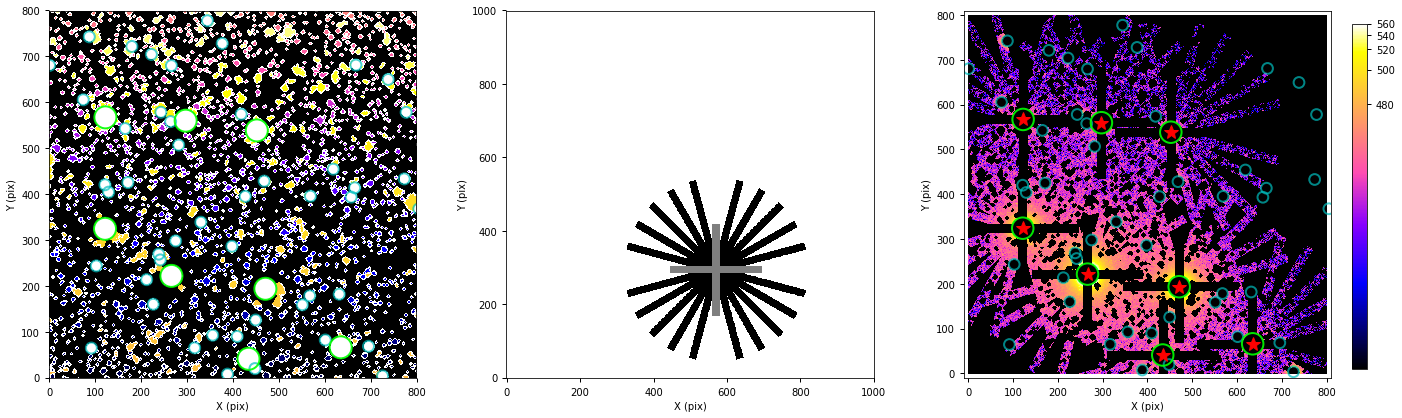

In [52]:
# In the same plot
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))

ax1.imshow(seg_map, cmap="gnuplot2")

ma_strip[ma_cross.astype(bool)]=0.5
ax2.imshow(ma_strip, cmap="gray_r")
# ax2.plot(star_pos[-1][0], star_pos[-1][1], "r*",ms=15)

image3 = image.copy()
image3[mask_comb] = 0
im3 = ax3.imshow(image3, cmap='gnuplot2', norm=norm1, vmin=mu, vmax=mu+100, origin='lower') 
ax3.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
ax3.set_xlim(-10,image_size+10)
ax3.set_ylim(-10,image_size+10)

aper1 = CircularAperture(star_pos[medbright], r=r_core_B)
aper2 = CircularAperture(star_pos[verybright], r=r_core_A)

for ax in [ax1,ax3]:
    aper1.plot(color='c',lw=2,label="",alpha=0.7, axes=ax)
    aper2.plot(color='lime',lw=2,label="",alpha=0.9, axes=ax)

for ax in [ax1,ax2,ax3]:
    ax.set_xlabel("X (pix)")
    ax.set_ylabel("Y (pix)")
    
plt.subplots_adjust(bottom=0.1,top=0.95,left=0.05,right=0.95, hspace=0.2, wspace=0.2)
cax = fig.add_axes([0.96, 0.12, 0.01, 0.8])
cb = plt.colorbar(im3, cax=cax)
    
# plt.savefig("Plots/Mask.pdf")

460.93146340177725 2.6034760954727445
0.721931074404748 459.40602772745956 2.112983189110177
mu: 460.87  std: 2.49 (masked S/N=2):


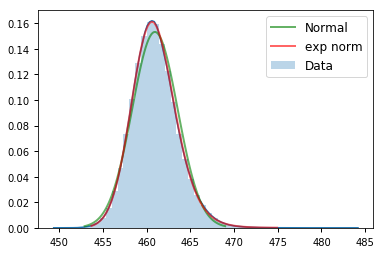

In [15]:
mask_deep0, seg_map0 = make_mask_map(image, sn_thre=3, b_size=25, npix=4, n_dilation=1)
display_background_distribution(image, mask_deep0)
mu_patch, _, std_patch = sigma_clipped_stats(image[~mask_deep0])
print("mu: %.2f  std: %.2f (masked S/N=2):"%(mu_patch, std_patch))


Total Time: 1.029s


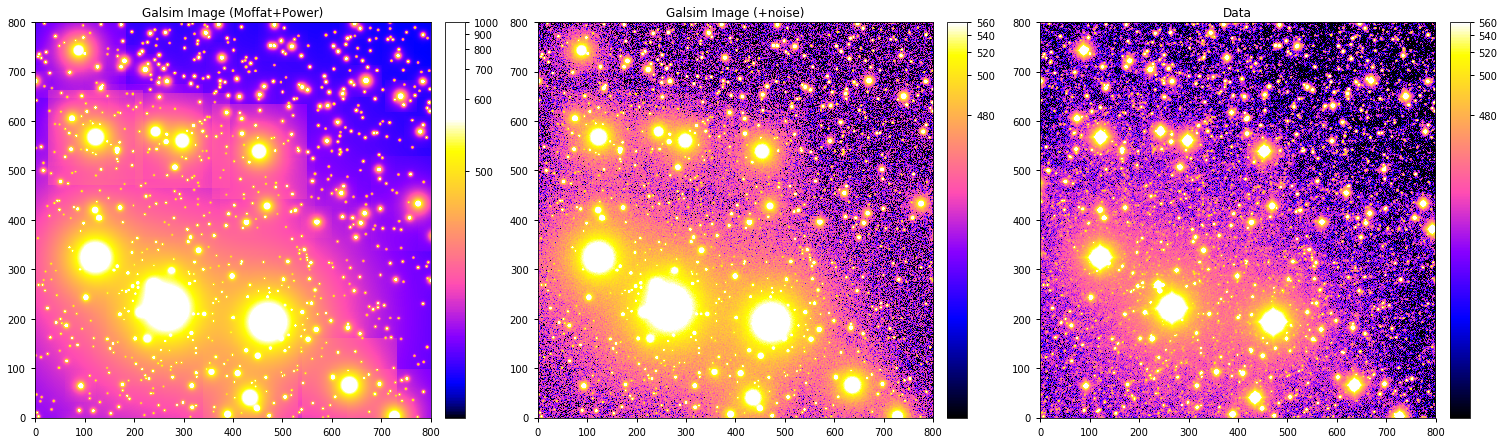

In [44]:
############################################
# Generate Image
############################################

def generate_image_galsim_scale(frac, n, mu,
                                star_pos=star_pos, 
                                scale=z_norm,
                                r_scale=R_scale,
                                image_size=image_size,
                                pixel_scale=pix_scale,
                                min_psf_range=90, 
                                max_psf_range=768,
                                parallel=False,
                                n_parallel=4,
                                draw_real=False,
                                n_real=2.5,
                                interpolant='linear'):
    
    psf_pow, psf_size_arcsec = Generate_PSF_pow_Galsim(contrast=3e4, n=n, theta_t=theta_t,
                                                       psf_scale=pixel_scale, psf_range=None,
                                                       min_psf_range=min_psf_range//2,
                                                       max_psf_range=max_psf_range//2,
                                                       interpolant=interpolant)
    
    # Rounded PSF size to 2^k or 3*2^k for faster FT
    psf_size = round_good_fft(psf_size_arcsec / psf_scale)
#     psf_size+=1

    # Setup the canvas
    full_image = galsim.ImageF(image_size, image_size)
    
    # Draw medium bright stars with galsim in Fourier space
    psf_star = (1-frac) * psf_mof + frac * psf_pow               
    
    # Recompute flux for stars < 15 mag:
    Amp_pow = scale * (r_scale/theta_t_pix)**n
    Flux_pow = power2d_Amp2Flux(n, theta_t_pix, Amp=Amp_pow)
    Flux2 = Flux_pow / frac
 
    Flux = np.concatenate([Flux1, Flux2])
    
    if (n >= n_parallel):
        parallel = False
        
    if not parallel:
        # Draw in serial
        for k in range(num_medbright):
            draw_star(k, star_pos=star_pos[medbright], Flux=Flux[medbright],
                      psf_star=psf_star, psf_size=psf_size,
                      full_image=full_image)
    else:
        # Draw in parallel, automatically back to serial computing if too few jobs 
        p_get_stamp_bounds = partial(get_stamp_bounds,
                                     star_pos=star_pos[medbright],
                                     Flux=Flux[medbright],
                                     psf_star=psf_star,
                                     psf_size=psf_size,
                                     full_image=full_image)
        
        results = parallel_compute(np.arange(num_medbright), p_get_stamp_bounds, cores=2,
                                   lengthy_computation=False, verbose=False)

        for (stamp, bounds) in results:
            full_image[bounds] += stamp[bounds]
           
    # Draw very bright star in real space / Fourier space       
    if (n < n_real) | (image_size<500):
        draw_real = True

    if draw_real:
        # Draw very bright star (if highter cost in FFT) in real space
        image_gs = full_image.array
        for (pos, flux) in zip(star_pos[verybright], Flux[verybright]):
            p2d_vb = trunc_power2d(xx, yy, n, cen=(pos[0], pos[1]),
                                   theta0=theta_t_pix, I_theta0=frac*flux * (n-2)/n /theta_t_pix**2/np.pi)
            image_gs += p2d_vb
    else:
        # Draw very bright star in Fourier space 
        psf_pow_vb , psf_size = Generate_PSF_pow_Galsim(contrast=3e5, n=n, theta_t=theta_t,
                                                        psf_scale=pixel_scale, psf_range=None,
                                                        min_psf_range=min_psf_range,
                                                        max_psf_range=max_psf_range,
                                                        interpolant=interpolant)
        psf_star = (1-frac) * psf_mof + frac * psf_pow_vb 
        
        psf_size = round_good_fft(psf_size)
        
        for k in range(num_verybright):
            try:
                draw_star(k, star_pos=star_pos[verybright], Flux=Flux[verybright],
                          psf_star=psf_star, psf_size=psf_size, full_image=full_image)
            except Exception as e:
                pass
        
        image_gs = full_image.array
                   
    image = image_gs.copy() + image_gs0 + mu # add the faint star base and background
    image[image>5e4] = 5e4
    return image

if draw:
    start = time.time()
    image_tri = generate_image_galsim_scale(frac=0.1, n=2.2, mu=mu, 
                                            star_pos=star_pos, scale=z_norm, parallel=True, draw_real=False)
    end = time.time()
    print("\nTotal Time: %.3fs"%(end-start))

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(21,7))
    im = ax1.imshow(image_tri, vmin=mu, vmax=1e3, norm=norm1, cmap="gnuplot2")
    colorbar(im)
    ax1.set_title("Galsim Image (Moffat+Power)")
    im = ax2.imshow(image_tri + noise_image, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
    ax2.set_title("Galsim Image (+noise)")
    colorbar(im)
    im = ax3.imshow(image, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")
    ax3.set_title("Data")
    colorbar(im)
    plt.tight_layout()   
    if save:
        plt.savefig("%s/Mock.png"%dir_name,dpi=150)
        plt.close()

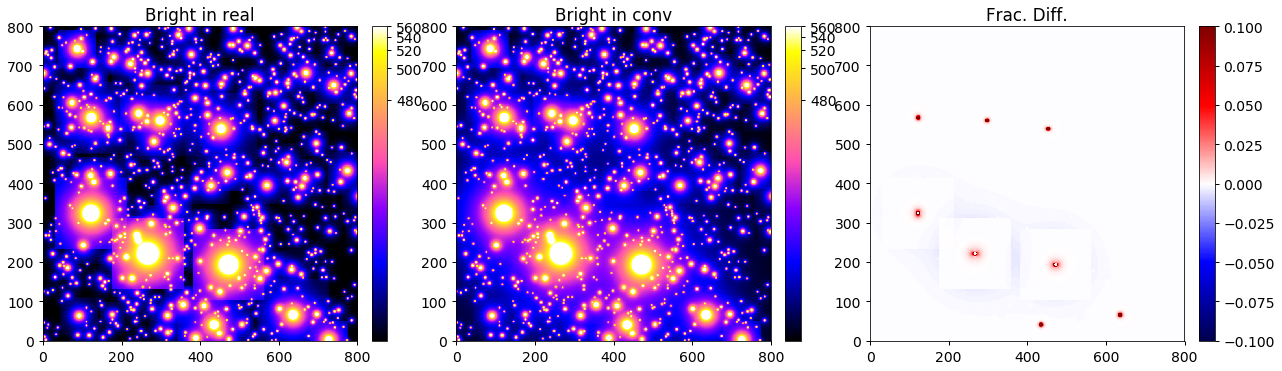

In [151]:
# Difference between real vs conv
img1 = generate_image_galsim_scale(frac=frac, n=n, mu=mu, 
                            star_pos=star_pos, scale=z_norm, parallel=True, draw_real = False)
img2 = generate_image_galsim_scale(frac=frac, n=n, mu=mu, 
                            star_pos=star_pos, scale=z_norm, parallel=True, draw_real = True)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(21,7))
im = ax1.imshow(img1, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")
colorbar(im)
im = ax2.imshow(img2, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
colorbar(im)
im = ax3.imshow((img1-img2)/img1, vmin=-0.1, vmax=0.1, cmap="seismic")
ax1.set_title("Bright in real")
ax2.set_title("Bright in conv")
ax3.set_title("Frac. Diff.")
colorbar(im)

Overall the galsim mock resembles the data in terms of bright source.

In the middle of the field, there is a pair of objects show clear deviation in light distribution. It is likely to be a pair of galaxy. If checked in Read_APASS.py one would find it has a shallower, extended profile instead of a steep, star-like profile.

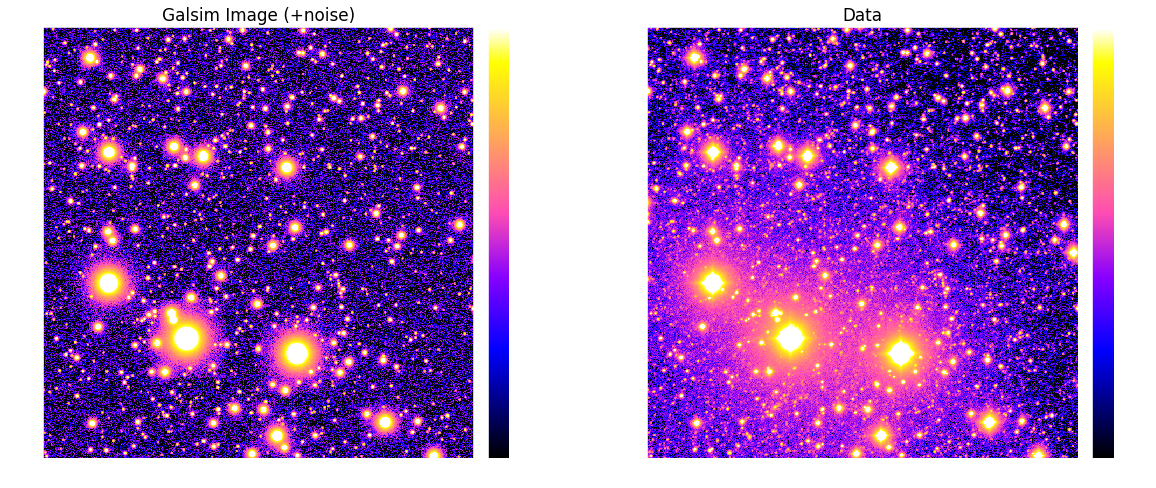

In [168]:
with plt.rc_context({'axes.edgecolor':'w', 'xtick.color':'w', 'ytick.color':'w','figure.facecolor':'None'}):

    fig, (ax2, ax3) = plt.subplots(1,2,figsize=(17,7))
    image_tri2 = image_tri + noise_image
    im = ax2.imshow(image_tri2, vmin=mu, vmax=mu+200, norm=norm1, cmap="gnuplot2")    
    ax2.set_title("Galsim Image (+noise)")
    colorbar(im)

    im = ax3.imshow(image, vmin=mu, vmax=mu+200, norm=norm1, cmap="gnuplot2")
    ax3.set_title("Data")
    colorbar(im)
    plt.tight_layout()   
#     plt.savefig("Plots/galsim_data.pdf",transparent=True)

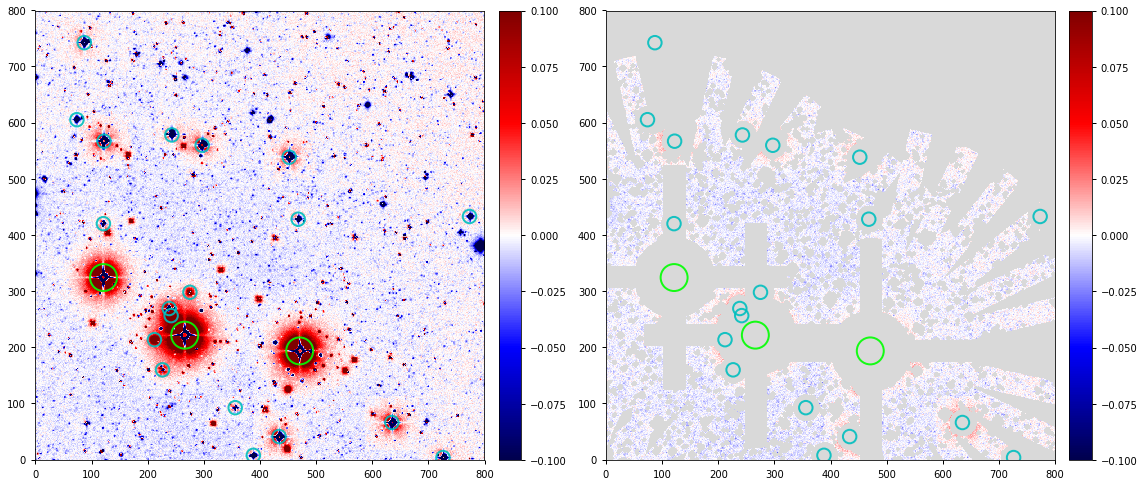

In [34]:
image_tri_1 = generate_image_galsim_scale(frac=frac, n=2.7, mu=mu, 
                                          star_pos=star_pos, scale=z_norm, parallel=True, draw_real=True)
img_diff = (image_tri_1-image)/image
plt.figure(figsize=(16,8))
ax1=plt.subplot(121)
im = plt.imshow(img_diff, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)

ax2=plt.subplot(122)
img_diff[mask_comb] = np.nan
im = plt.imshow(img_diff, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)

aper1 = CircularAperture(star_pos[medbright], r=12)
aper2 = CircularAperture(star_pos[verybright], r=24)
for ax in [ax1,ax2]:
    aper1.plot(color='c',lw=2,alpha=0.9,axes=ax)
    aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax)

plt.tight_layout()

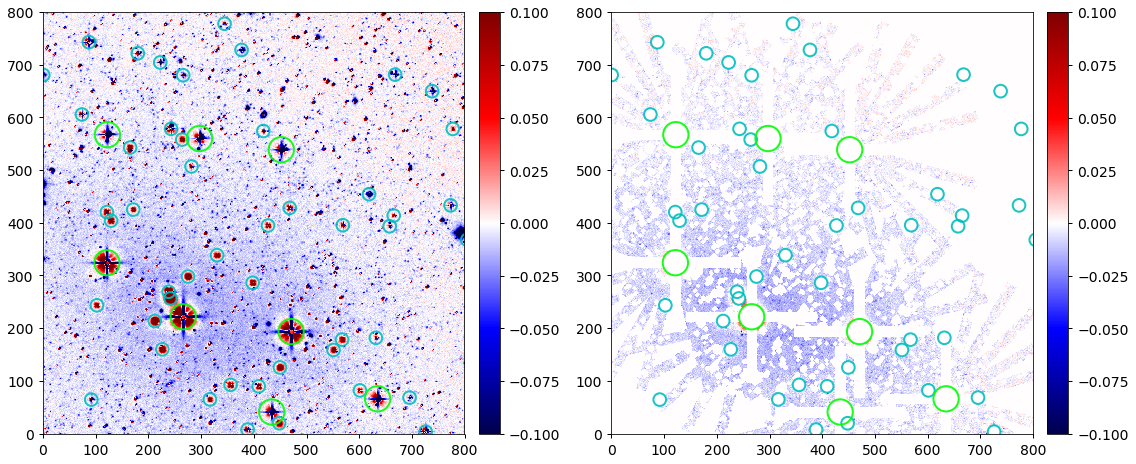

In [184]:
image_tri_1 = generate_image_galsim_scale(frac=frac, n=3.3, mu=mu, 
                                          star_pos=star_pos, scale=z_norm, parallel=True, draw_real=True)
img_diff = (image_tri_1-image)/image
plt.figure(figsize=(16,8))
ax1=plt.subplot(121)
im = plt.imshow(img_diff, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)

ax2=plt.subplot(122)
img_diff[mask_comb] = 0
im = plt.imshow(img_diff, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)

aper1 = CircularAperture(star_pos[medbright], r=12)
aper2 = CircularAperture(star_pos[verybright], r=24)
for ax in [ax1,ax2]:
    aper1.plot(color='c',lw=2,alpha=0.9,axes=ax)
    aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax)

plt.tight_layout()

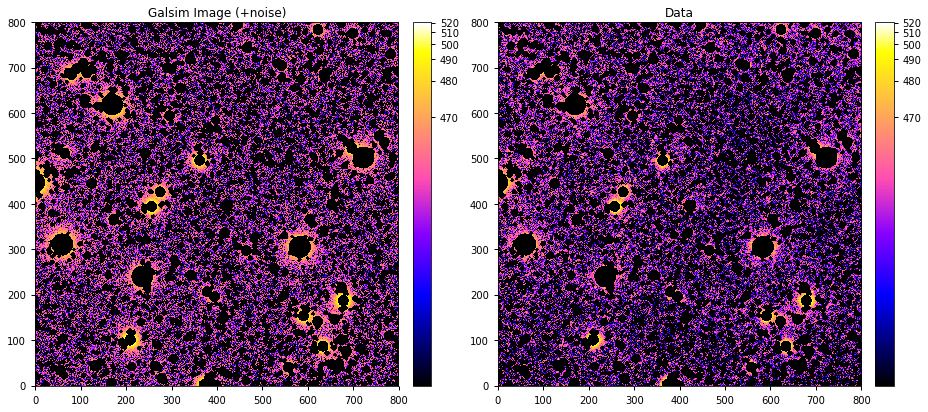

In [28]:
fig, (ax2, ax3) = plt.subplots(1,2,figsize=(13,6))
image_tri2 = image_tri + noise_image
image_tri2[mask_deep]  = 0
im = ax2.imshow(image_tri2, vmin=mu, vmax=mu+20*sigma, norm=norm1, origin="lower", cmap="gnuplot2")    
ax2.set_title("Galsim Image (+noise)")
colorbar(im)

image2 = image.copy()
image2[mask_deep] = 0
im = ax3.imshow(image2, vmin=mu, vmax=mu+20*sigma, norm=norm1, origin="lower", cmap="gnuplot2")
ax3.set_title("Data")
colorbar(im)
plt.tight_layout()   

Estimate of Background: (463.272, 2.980)


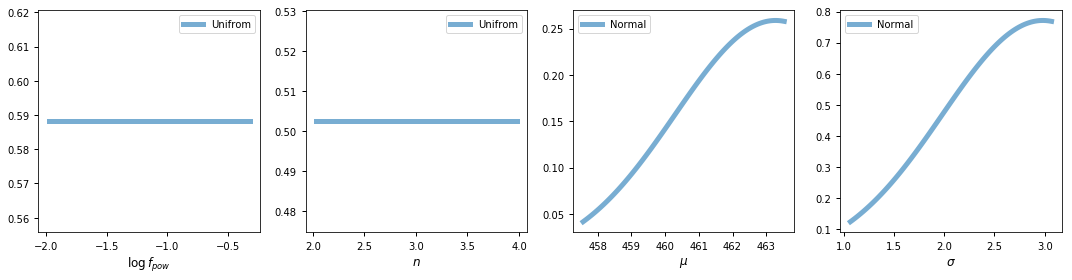

In [35]:
############################################
# Priors and Likelihood Models for Fitting
############################################

import dynesty
import time
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import multiprocess as mp


if mask_strip is True:
    mask_fit = mask_comb
else:
    mask_fit = mask_deep
    
labels = [r'$\log\,f_{pow}$', r'$n$', r'$\mu$', r'$\sigma$']

mu_patch, std_patch = np.median(image[~mask_fit]), np.std(image[~mask_fit])
print("Estimate of Background: (%.3f, %.3f)"%(mu_patch, std_patch))

Prior_f = stats.uniform(loc=-2, scale=1.7)                            # f : 0.01-0.5
Prior_n = stats.uniform(loc=2.01, scale=1.99)                         # n : 2.2-4
Prior_mu = stats.truncnorm(a=-2, b=0.1, loc=mu_patch, scale=std_patch)  # mu
Prior_sigma = stats.truncnorm(a=-2, b=0.1, loc=std_patch, scale=1)    # sigma 

Priors = [Prior_f, Prior_n, Prior_mu, Prior_sigma]
prior_tf = build_priors(Priors)

if draw:
    draw_prior(Priors, xlabels=labels, plabels=['Unifrom', 'Unifrom','Normal','Normal'])
    
# def prior_transform(u):
#     v = u.copy()
#     v[0] = u[0] * 0.7 - 1 # frac : 0.1-0.5
#     v[1] = u[1] * 2.99 + 2.01  # n : 2-5
#     v[2] = stats.truncnorm.ppf(u[2], a=-1, b=1, loc=mu_patch, scale=std_patch)  # mu : peak around 884
#     v[3] = stats.truncnorm.ppf(u[3], a=-2, b=2, loc=std_patch, scale=0.5)  # sigma : 2 < N(3, 2) < 4
#     return v
    
X = np.array([xx,yy])
Y = image[~mask_fit].copy().ravel()

def loglike(v):
    logfrac, n, mu, sigma = v
    frac = 10**logfrac
    
    image_tri = generate_image_galsim_scale(frac, n, mu, star_pos=star_pos, scale=z_norm,
                                            image_size=image_size, parallel=False)
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike


def prior_tf_VN(u):
    v = u.copy()
    v[0] = u[0] * 1.7 - 2 # frac : 0.01-0.5
    v[1] = u[1] * 2.99 + 2.01  # n : 2-5
    v[2] = stats.truncnorm.ppf(u[2], a=-1, b=1, loc=mu_patch, scale=std_patch)  # mu : peak around 884
    v[3] = stats.truncnorm.ppf(u[3], a=-2, b=2, loc=std_patch, scale=0.5)  # sigma : 2 < N(3, 2) < 4
    v[4] = stats.truncnorm.ppf(u[4], a=-2, b=2, loc=0.1, scale=0.02)  # eta : N(0.1, 0.02)
    return v

def loglike_VN(v):
    logfrac, n, mu, sigma0, eta = v
#     logfrac, n, mu, sigma0 = v
#     eta = 0.1
    
    frac = 10**logfrac
    
    image_tri = generate_image_galsim_scale(frac, n, mu, star_pos=star_pos, scale=z_norm,
                                            image_size=image_size, parallel=True, draw_real=False)
    ypred = image_tri[~mask_fit].ravel()
    sigma = np.sqrt((abs(ypred - Y)*eta/0.434)**2 + sigma0**2)
    
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

def Run_Nested_Fitting(loglike, prior_transform, ndim=4,
                       nlive_init=150, nlive_batch=50, maxbatch=2,
                       print_progress=print_progress):
        
    with mp.Pool(processes=n_cpu-1) as pool:
        print("Opening pool: # of CPU used: %d"%(n_cpu))
        pool.size = n_cpu

        dlogz = 1e-3 * (nlive_init - 1) + 0.01

        pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=nlive_init, 
                             nlive_batch=nlive_batch, 
                             maxbatch=maxbatch,
                             print_progress=print_progress, 
                             dlogz_init=dlogz, 
                             wt_kwargs={'pfrac': 0.8})
    return pdsampler

#### Region: [3100,1400,4100,2400]
#### Fitted patch: 800 X 800  
#### Dual Mask : S/N = 3   +   $\bf R_{core} = 1\,(0.5)\,arcmin$   +   Gaussian Noise

Run Nested Fitting for the image... Dim of paramas: 4
Opening pool: # of CPU used: 3


iter: 3444 | batch: 2 | bound: 800 | nc: 416 | ncall: 134424 | eff(%):  2.562 | loglstar: -654291.984 < -654287.469 < -654290.868 | logz: -654315.495 +/-  0.718 | stop:  4.397                       


Finish Fitting! Total time elapsed: 1.5e+04s


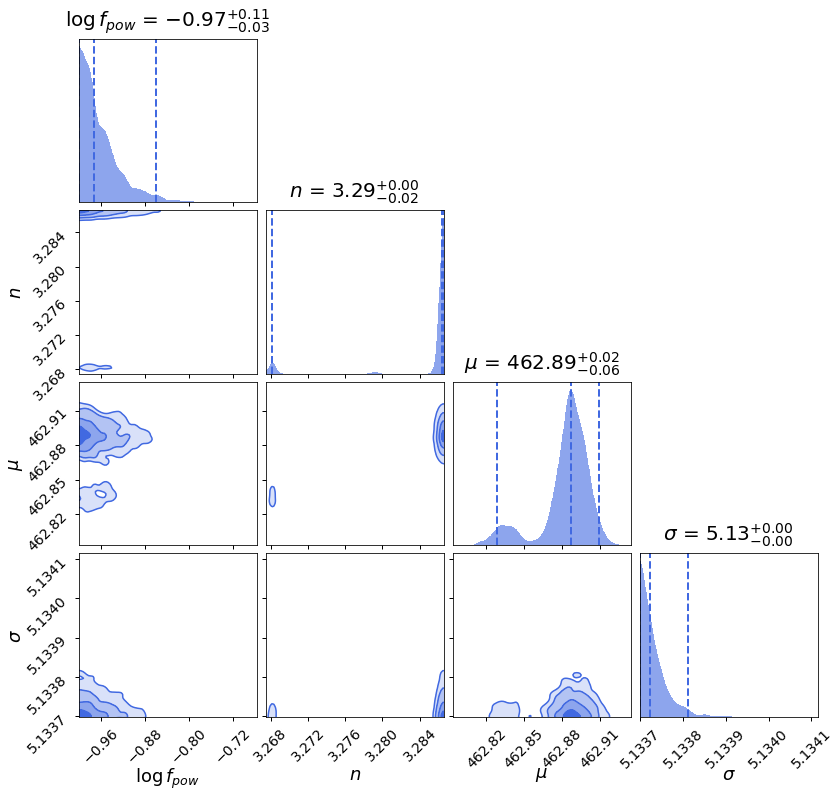

In [171]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim=4, 
                                           nlive_init=100, nlive_batch=50, maxbatch=2)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, show_titles=True, 
                                  color="royalblue", 
                                  labels=labels,
                                  title_kwargs={'fontsize':20, 'y': 1.04}, 
                                  label_kwargs={'fontsize':18},
                                  fig=plt.subplots(4, 4, figsize=(12, 11)))

In [172]:
chi2_reduced = cal_reduced_chi2(pdres, Y)

Reduced Chi^2: 0.35933


In [231]:
# Difference between real vs conv
pmed, pmean, pcov = get_params_fit(pdres)
logf_fit, n_fit, mu_fit, sigma_fit = pmed

img_fit = generate_image_galsim_scale(frac=10**logf_fit, n=n_fit, mu=mu_fit, 
                                      star_pos=star_pos, scale=z_norm, parallel=True, draw_real = True)
noise_fit = make_noise_image(image_size, sigma_fit**2)
img_fit += noise_fit

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
im = ax1.imshow(img_fit, vmin=mu_fit, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")
colorbar(im)
im = ax2.imshow(image, vmin=mu_fit, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")    
colorbar(im)
diff = (img_fit-image)/image
im = ax3.imshow(diff, vmin=-0.1, vmax=0.1, cmap="seismic")
diff = (img_fit-image)/image
colorbar(im)

aper1 = CircularAperture(star_pos[medbright], r=r_core_B)
aper2 = CircularAperture(star_pos[verybright], r=r_core_A)
aper1.plot(color='c',lw=2,alpha=0.9,axes=ax3)
aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax3)

diff[mask_fit] = np.nan
im = ax4.imshow(diff, vmin=-0.05, vmax=0.05, cmap="seismic")
colorbar(im)

ax1.set_title("Fitted I$_f$")
ax2.set_title("Data I$_0$")
ax3.set_title("(I$_f$ - I$_0$) / I$_0$")
ax4.set_title("(I$_f$ - I$_0$) / I$_0$  (w/ mask)")

plt.tight_layout()
plt.savefig("Comparison_fit_data-G-X%dY%d.png"%(patch_Xmin0, patch_Ymin0),dpi=120)

In [232]:
# plot_fit_PSF(pdres, n_bootstrap=500, image_size=image_size)

In [190]:
save_nested_fitting_result(pdres, filename='./NGC5907-G-fit_best_X3100Y1400.res')

Run Nested Fitting for the image... Dim of paramas: 4
Opening pool: # of CPU used: 3


iter: 2717 | batch: 2 | bound: 65 | nc: 1 | ncall: 13079 | eff(%): 20.774 | loglstar: -477090.277 < -477086.327 < -477088.566 | logz: -477107.557 +/-  0.622 | stop:  4.343                           


Finish Fitting! Total time elapsed: 1.79e+03s


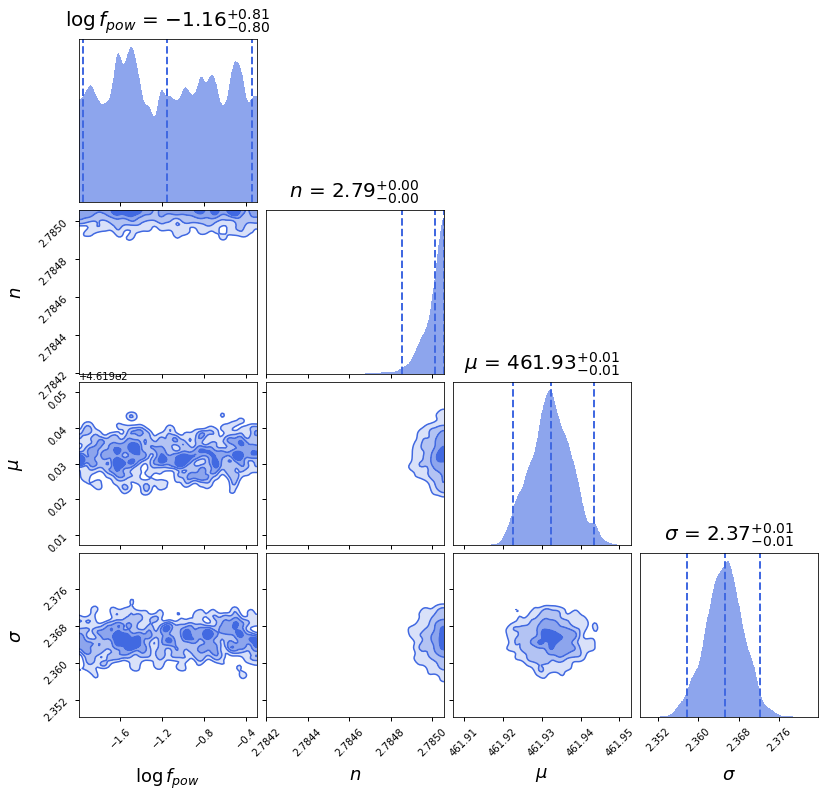

In [37]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim=4, 
                                           nlive_init=100, nlive_batch=50, maxbatch=2)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, show_titles=True, 
                                  color="royalblue", 
                                  labels=labels,
                                  title_kwargs={'fontsize':20, 'y': 1.04}, 
                                  label_kwargs={'fontsize':18},
                                  fig=plt.subplots(4, 4, figsize=(12, 11)))

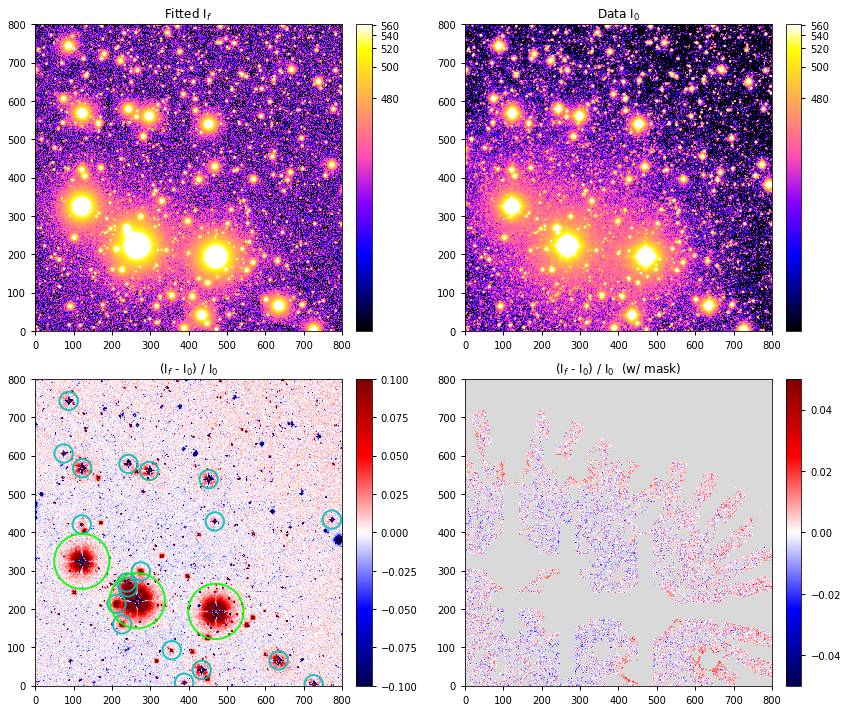

In [43]:
# Difference between real vs conv
pmed, pmean, pcov = get_params_fit(pdres)
logf_fit, n_fit, mu_fit, sigma_fit = pmed

img_fit = generate_image_galsim_scale(frac=10**logf_fit, n=n_fit, mu=mu_fit, 
                                      star_pos=star_pos, scale=z_norm, parallel=True, draw_real = True)
noise_fit = make_noise_image(image_size, sigma_fit**2)
img_fit += noise_fit

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
im = ax1.imshow(img_fit, vmin=mu_fit-1, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")
colorbar(im)
im = ax2.imshow(image, vmin=mu_fit-1, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")    
colorbar(im)
diff = (img_fit-image)/image
im = ax3.imshow(diff, vmin=-0.1, vmax=0.1, cmap="seismic")
diff = (img_fit-image)/image
colorbar(im)

aper1 = CircularAperture(star_pos[medbright], r=r_core_B)
aper2 = CircularAperture(star_pos[verybright], r=r_core_A)
aper1.plot(color='c',lw=2,alpha=0.9,axes=ax3)
aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax3)

diff[mask_fit] = np.nan
im = ax4.imshow(diff, vmin=-0.05, vmax=0.05, cmap="seismic")
colorbar(im)

ax1.set_title("Fitted I$_f$")
ax2.set_title("Data I$_0$")
ax3.set_title("(I$_f$ - I$_0$) / I$_0$")
ax4.set_title("(I$_f$ - I$_0$) / I$_0$  (w/ mask)")

plt.tight_layout()
# plt.savefig("Comparison_fit_data-G-X%dY%d.png"%(patch_Xmin0, patch_Ymin0),dpi=120)

In [41]:
chi2_reduced = cal_reduced_chi2(pdres, Y)

Reduced Chi^2: 0.99990


Fitting (mean):  [ -1.15175395   2.78499813 461.93239078   2.36513342]
Fitting (median):  [ -1.15553728   2.78501443 461.93224525   2.36520676]
2643214.6874619466 1057.661772445025
2641476.6975351567 1057.694568483241


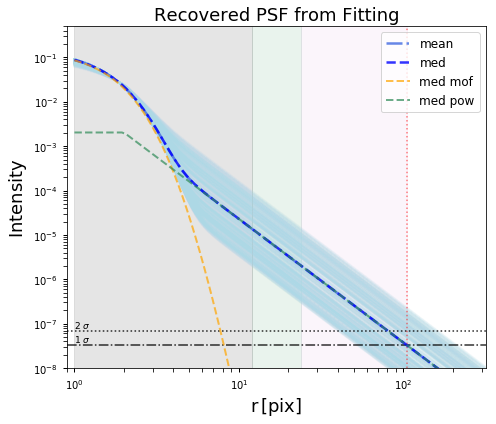

In [42]:
plot_fit_PSF(pdres, n_bootstrap=500, image_size=image_size)

#### Region: [800,800,1800,1800] 
#### Fitted patch: 800 X 800  
#### Dual Mask : S/N = 3   +   $\bf R_{core} = 1\,(0.5)\,arcmin$   +   Gaussian Noise

Run Nested Fitting for the image... Dim of paramas: 4
Opening pool: # of CPU used: 3


iter: 2426 | batch: 2 | bound: 70 | nc: 5 | ncall: 13663 | eff(%): 17.756 | loglstar: -484303.150 < -484300.227 < -484301.503 | logz: -484318.615 +/-  0.576 | stop:  4.146                           


Finish Fitting! Total time elapsed: 1.26e+03s


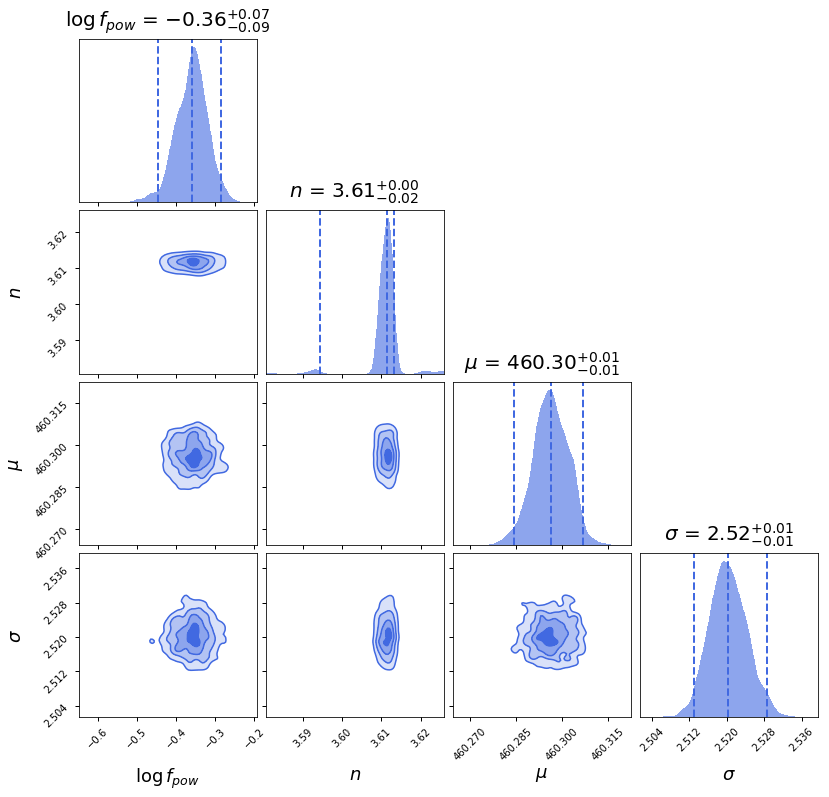

In [30]:
if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim=4, 
                                           nlive_init=100, nlive_batch=50, maxbatch=2)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, show_titles=True, 
                                  color="royalblue", 
                                  labels=labels,
                                  title_kwargs={'fontsize':20, 'y': 1.04}, 
                                  label_kwargs={'fontsize':18},
                                  fig=plt.subplots(4, 4, figsize=(12, 11)))

In [225]:
chi2_reduced = cal_reduced_chi2(pdres, Y)

Reduced Chi^2: 1.00189


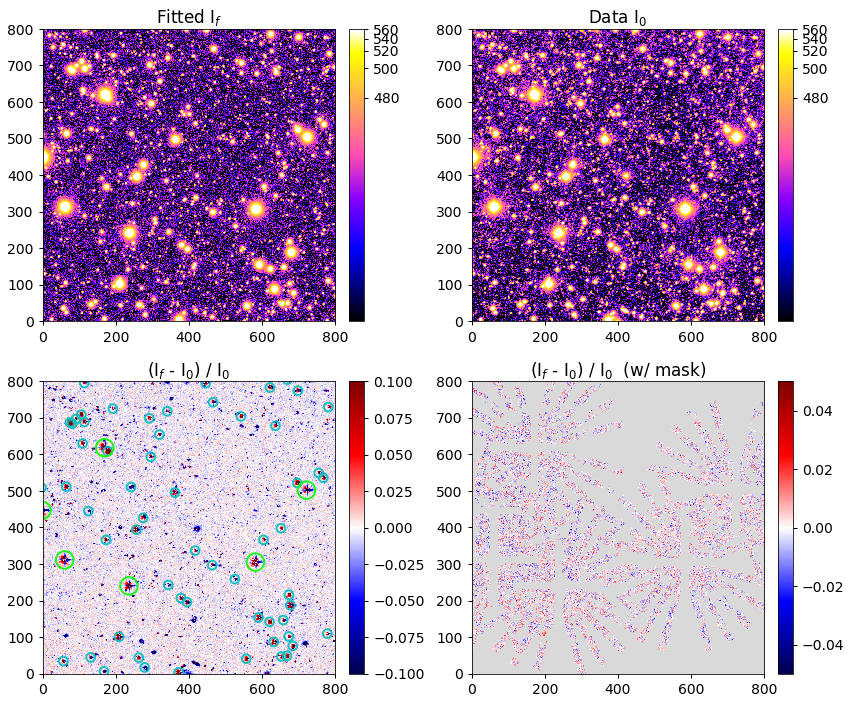

In [230]:
# Difference between real vs conv
pmed, pmean, pcov = get_params_fit(pdres)
logf_fit, n_fit, mu_fit, sigma_fit = pmed

img_fit = generate_image_galsim_scale(frac=10**logf_fit, n=n_fit, mu=mu_fit, 
                                      star_pos=star_pos, scale=z_norm, parallel=True, draw_real = True)
noise_fit = make_noise_image(image_size, sigma_fit**2)
img_fit += noise_fit

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
im = ax1.imshow(img_fit, vmin=mu_fit, vmax=mu+100, norm=norm1, cmap="gnuplot2")
colorbar(im)
im = ax2.imshow(image, vmin=mu_fit, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
colorbar(im)
diff = (img_fit-image)/image
im = ax3.imshow(diff, vmin=-0.1, vmax=0.1, cmap="seismic")
diff = (img_fit-image)/image
colorbar(im)
aper1.plot(color='c',lw=2,alpha=0.9,axes=ax3)
aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax3)

diff[mask_fit] = np.nan
im = ax4.imshow(diff, vmin=-0.05, vmax=0.05, cmap="seismic")
colorbar(im)

ax1.set_title("Fitted I$_f$")
ax2.set_title("Data I$_0$")
ax3.set_title("(I$_f$ - I$_0$) / I$_0$")
ax4.set_title("(I$_f$ - I$_0$) / I$_0$  (w/ mask)")

plt.tight_layout()
plt.savefig("Comparison_fit_data-G-X800Y1800.png",dpi=120)

Fitting (mean):  [-3.38935312e-01  3.61059778e+00  4.60301111e+02  2.52037734e+00]
Fitting (median):  [-3.36250690e-01  3.61124376e+00  4.60301204e+02  2.52049825e+00]
217514.50953953736 140.95116325127447
218661.20297802772 140.95792510608686


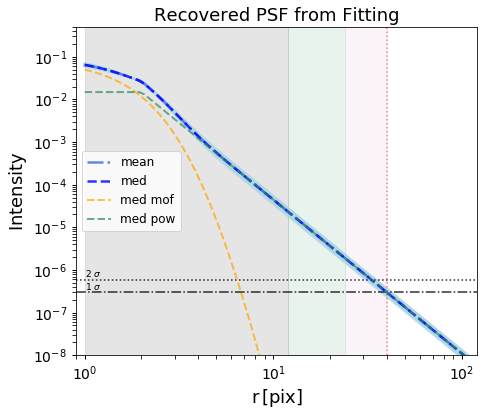

In [233]:
plot_fit_PSF(pdres, n_bootstrap=1000, image_size=image_size)

In [234]:
save_nested_fitting_result(pdres, filename='./NGC5907-G-fit_best_X%dY%d.res'%(patch_Xmin0, patch_Ymin0))

In [40]:
def cal_reduced_chi2(res, data):
    pmed, pmean, pcov = get_params_fit(res)
    f_fit, n_fit, mu_fit, sigma_fit = pmed
    image_pred = generate_image_galsim_scale(frac=f_fit, n=n_fit, mu=mu_fit,
                                            star_pos=star_pos, scale=z_norm)
    chi2_reduced = np.sum((image_pred[~mask_fit].ravel()-data)**2/sigma_fit**2)/(len(data)-len(pmed))
    print("Reduced Chi^2: %.5f"%chi2_reduced)
    return chi2_reduced

def cal_reduced_chi2VN(res, data):
    pmed, pmean, pcov = get_params_fit(res)
    f_fit, n_fit, mu_fit, sigma0_fit, eta_fit = pmed
    image_pred = generate_image_galsim_scale(frac=f_fit, n=n_fit, mu=mu_fit,
                                            star_pos=star_pos, scale=z_norm)
    res = image_pred[~mask_fit].ravel()-data
    sigma_fit = np.sqrt((abs(res)*eta_fit/0.434)**2 + sigma0_fit**2)

    chi2_reduced = np.sum(res**2/sigma_fit**2)/(len(data)-len(pmed))
    print("Reduced Chi^2: %.5f"%chi2_reduced)
    return chi2_reduced

def plot_fit_PSF(res, image_size=image_size, r_scale=10, 
                 n_bootstrap=200, save=False, dir_name="."):

    samples = res.samples                                 # samples
    weights = np.exp(res.logwt - res.logz[-1])            # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)     # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)  # resample weighted samples
    pmed = np.median(samples_eq,axis=0)                    # median sample
    
    print("Fitting (mean): ", pmean)
    print("Fitting (median): ", pmed)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootstrap)[0]
    
    c_mof2Dto1D =  C_mof2Dto1D(gamma_pix, beta_psf)
    c_pow2Dto1D = C_pow2Dto1D(n, theta_t_pix)
    
    r = np.logspace(0., np.log10(image_size//2), 100)
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D
    
    plt.figure(figsize=(7,6))
    
    for (logfrac_k, n_k, _, _) in samples_eq_bs:
        frac_k = 10**logfrac_k
        comp2_k = trunc_power1d_normed(r, n_k, theta_t_pix) / c_pow2Dto1D

        plt.semilogy(r, (1-frac_k) * comp1 + frac_k * comp2_k,
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([pmed, pmean], ["royalblue", "b"],
                                  ["-.","--"], ["mean", "med"]):
            f_fit = 10**fits[0]
            n_fit = fits[1]
            comp2 = trunc_power1d_normed(r, n_fit, theta_t_pix) / c_pow2Dto1D
            y_fit = (1-f_fit) * comp1 + f_fit * comp2
            
            plt.semilogy(r, y_fit, color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
            if l=="med":
                plt.semilogy(r, (1-f_fit) * comp1,
                             color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=4)
                plt.semilogy(r, f_fit * comp2,
                             color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=4)
                
            std_fit = fits[-1]
            Amp_max = moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-f_fit)*Flux.max())
            
            contrast = Amp_max/3
            y_min_contrast = y_fit.max()/contrast
            plt.axhline(y_min_contrast, color="k", ls="-.", alpha=0.5)
            plt.axhline(y_min_contrast*2, color="k", ls=":", alpha=0.5)
            
            z_max = z_norm.max()
            contrast2 = z_max/std_fit

    r_bond = r_scale / (contrast)**(1./n_fit)
    plt.axvline(r_bond, color="b", ls=":", alpha=0.5)
    
    r_bond = r[np.argmin(abs(y_min_contrast-y_fit))]
    plt.axvline(r_bond, color="r", ls=":", alpha=0.5)
    
    plt.axvspan(12, 24, color="seagreen",  alpha=0.1)
    plt.axvspan(24, r_bond, color="plum", alpha=0.1)
    plt.text(1, y_min_contrast*1.15, "1 $\sigma$", fontsize=9)
    plt.text(1, y_min_contrast*2.35, "2 $\sigma$", fontsize=9)
    plt.axvspan(1, 12, color="gray", alpha=0.2)
    
    plt.legend(fontsize=12)    
    plt.xlabel(r"$\rm r\,[pix]$",fontsize=18)
    plt.ylabel(r"$\rm Intensity$",fontsize=18)
    plt.title("Recovered PSF from Fitting",fontsize=18)
    plt.xscale("log")
    plt.xlim(0.9, 3*r_bond)    
    plt.ylim(1e-8, 0.5)    
    plt.tight_layout()
    if save:
        plt.savefig("%s/Fit_PSF.png"%dir_name,dpi=150)
        plt.close()